In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy import special
import scipy.linalg
import pandas as pd
from scipy.linalg import cholesky
from tqdm import trange
%matplotlib inline

In [16]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [17]:
def dynamics(dt, state, RW, GM_param, GM_noise, w_input_noise, num_imus):
    state_next = np.zeros(6+3*num_imus+len(GM_param)) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:6+3*num_imus] = state[6:6+3*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    state_next[6+3*num_imus:6+3*num_imus+len(GM_param)] = GM_param*state[6+3*num_imus:6+3*num_imus+len(GM_param)] + GM_noise*np.random.randn(len(GM_noise))
    return state_next

def dynamics_est(dt, state, GM_param, num_imus):
    state_next = np.zeros((len(state),6+3*num_imus+len(GM_param)))
    for i in range(len(state)):
        state_next[i,0:3] = state[i,0:3] + state[i,3:6] * dt          # omega
        state_next[i,3:6] = np.zeros(3)                               # omega_dot
        state_next[i,6:6+3*num_imus] = state[i,6:6+3*num_imus]        # Rate random walk state
        state_next[i, 6+3*num_imus:6+3*num_imus+len(GM_param)] = np.diag(GM_param) @ state[i, 6+3*num_imus:6+3*num_imus+len(GM_param)]
    return state_next

In [18]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def measurement(state, Rb_si, WN, QN, GM_param, num_imus):
    meas = np.zeros(3*num_imus)
    GM = state[6+3*num_imus:6+3*num_imus+len(GM_param)]
    for i in range(num_imus):
        Q_noise_sub = 0.5 * QN[i] * (1.0 + special.erf(state[len(state)-3*(num_imus-i)-3:len(state)-3*(num_imus-i)] / np.sqrt(2))) - 0.5 * QN[i]
        Rb_si_sub = Rb_si[i]
        omega = state[0:3]
        omega_dot = state[3:6]
        RW_sub = state[6+3*i:9+3*i]
        GM_sub = GM[9*i:9+9*i]
        GM_sum = GM_sub[0:3] + GM_sub[3:6] + GM_sub[6:9]
        omega_i = Rb_si_sub @ omega + WN[i*num_imus:3+i*num_imus]*np.random.randn(3) + Q_noise_sub + RW_sub + GM_sum
        meas[i*3:3+i*3] = omega_i
    return meas

def measurement_est(state_input, Rb_si, QN, GM_param, num_imus):
    meas = np.zeros((3*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        GM = state[6+3*num_imus:6+3*num_imus+len(GM_param)]
        for i in range(num_imus):
            Q_noise_sub = 0.5 * QN[i] * (1.0 + special.erf(state[len(state)-3*(num_imus-i)-3:len(state)-3*(num_imus-i)] / np.sqrt(2))) - 0.5 * QN[i]
            Rb_si_sub = Rb_si[i]
            omega = state[0:3]
            omega_dot = state[3:6]
            RW_sub = state[6+3*i:9+3*i]
            GM_sub = GM[9*i:9+9*i]
            GM_sum = GM_sub[0:3] + GM_sub[3:6] + GM_sub[6:9]
            omega_i = Rb_si_sub @ omega + Q_noise_sub + RW_sub + GM_sum
            meas[i*3:3+i*3, j] = omega_i

    return meas

In [19]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, Rb_si, QN, GM_param, num_imus):
	alpha = 0.04
	kappa = 0
	beta = 2.0

	# Generate 2n+1 particles for every state
	n = len(state)
	Particles = np.zeros((2*n+1, n))                                                                                                                                                                                                                                                                                                                                                                                                       
	Particles[0] = state
	param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
	
	# delx = cholesky((n+param_lambda)*Cov)
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	
	for i in range(n):
		Particles[i+1] = state + delx[i].real
		Particles[n+i+1] = state - delx[i].real

	# Propagate the particles according to discrete time dynamics (2n+1 particles)
	Particles_prior = dynamics_est(dt, Particles, GM_param, num_imus)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	x = np.sum(wi_mc*Particles_prior[1:], axis=0)
	state_prior = w0_m*Particles_prior[0] + np.sum(wi_mc*Particles_prior[1:], axis=0)
	diff = Particles_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(Particles_prior)):
		diff = Particles_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	# print(Cov_prior)
	# Cov_prior = w0_c*(Particles_prior[0] - state_prior)*(Particles_prior[0] - state_prior).T
	# for i in range(1, len(Particles_prior)):
	# 	Cov_prior = Cov_prior + wi_mc*(Particles_prior[i] - state_prior)*(Particles_prior[i] - state_prior).T
	Cov_prior = Cov_prior + R

	# Regenerate particles
	# delx = np.linalg.cholesky((n+param_lambda)*Cov_prior)
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov_prior)
	Particles_rev = np.zeros((2*n+1, n))
	Particles_rev[0] = state_prior
	for i in range(n):
		Particles_rev[i+1] = state + delx[i].real
		Particles_rev[n+i+1] = state - delx[i].real

	# Predict measurements for each particle
	Y_part = measurement_est(Particles_rev, Rb_si, QN, GM_param, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
		# S = S + wi_mc*(Y_part[i] - y_hat)*(Y_part[i] - y_hat).T
	S = S + Q


	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		Particles_diff = Particles_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		Particles_col = Particles_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (Particles_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T
	# print(np.linalg.eigvals(Cov_prior))

	return state_est, Cov_est

In [20]:
# measurements
measurements = np.array(read_txt("data/gyro.txt"))

In [21]:
num_imus = 3

# Other DISI Kit params
# Positions in 3xN where each column is position of 1 IMU
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
w_input_noise = 1e-5
RW  = 1e-4 * np.ones(3*num_imus)
WN  = 1e-4 * np.ones(3*num_imus)
QN  = 1e-12 * np.ones(3*num_imus)
GM1 = 1e-12 * np.ones(3*num_imus)
GM2 = 1e-12 * np.ones(3*num_imus)
GM3 = 1e-12 * np.ones(3*num_imus)
GM_param = [GM1, GM2, GM3]
GM_param = np.concatenate(GM_param)
GM_noise = GM_param

dt = 0.01
time = np.arange(0, 360, 0.01)


# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(6 + 3*num_imus + len(GM_param))
state_est = np.zeros(6 + 3*num_imus + len(GM_param))
state_hist = np.zeros((len(time), 6 + 3*num_imus + len(GM_param)))
state_est_hist = np.zeros((len(time), 6 + 3*num_imus + len(GM_param)))
meas = np.zeros(3*num_imus)
meas_hist = np.zeros((len(time),3*num_imus))


# Covariance of dynamics
R = np.zeros((6 + 3*num_imus + len(GM_param), 6 + 3*num_imus + len(GM_param)))
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:6+3*num_imus, 6:6+3*num_imus] = np.diag(RW**2)
R[6+3*num_imus:6+3*num_imus+len(GM_param), 6+3*num_imus:6+3*num_imus+len(GM_param)] = np.diag(GM_noise**2)

Q = np.diag(WN**2)
Cov_est = 1e-4*np.eye(6+3*num_imus+len(GM_param))

for i in trange(len(time)):
    state_hist[i] = state
    state = dynamics(dt, state, RW, GM_param, GM_noise, w_input_noise, num_imus)
    meas = measurements[i]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, Rb_si, QN, GM_param, num_imus)
    state_est_hist[i] = state_est


100%|██████████| 36000/36000 [20:51<00:00, 28.77it/s]


Text(0, 0.5, '$\\hat{\\omega}$ (rad/s)')

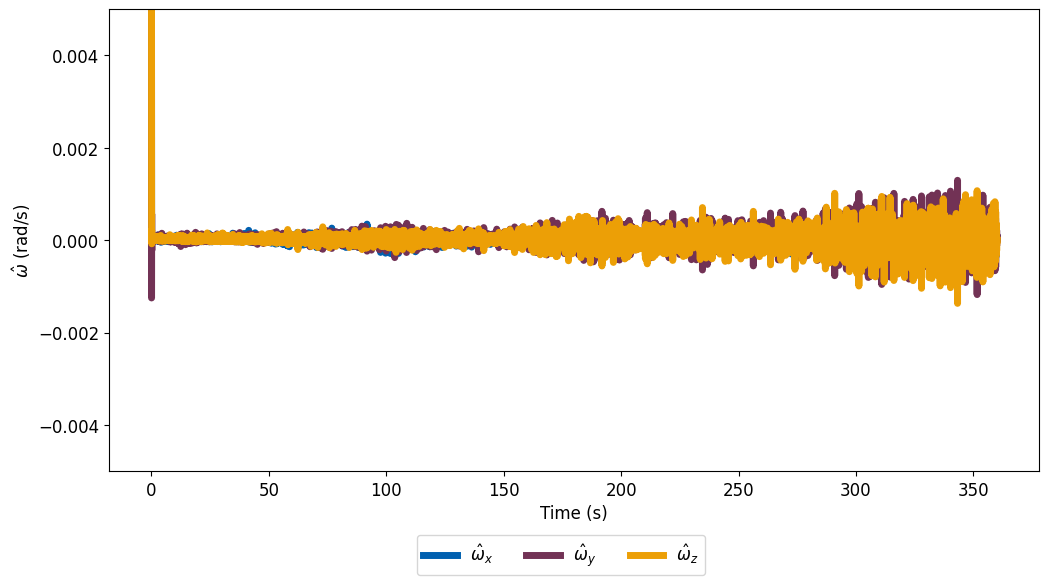

In [22]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,0])
# plt.plot(time, state_est_hist[:,1])
# plt.plot(time, state_est_hist[:,2])
# plt.title("omega")

fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ (rad/s)", fontsize=12)

Text(0, 0.5, '$\\omega$ (rad/s)')

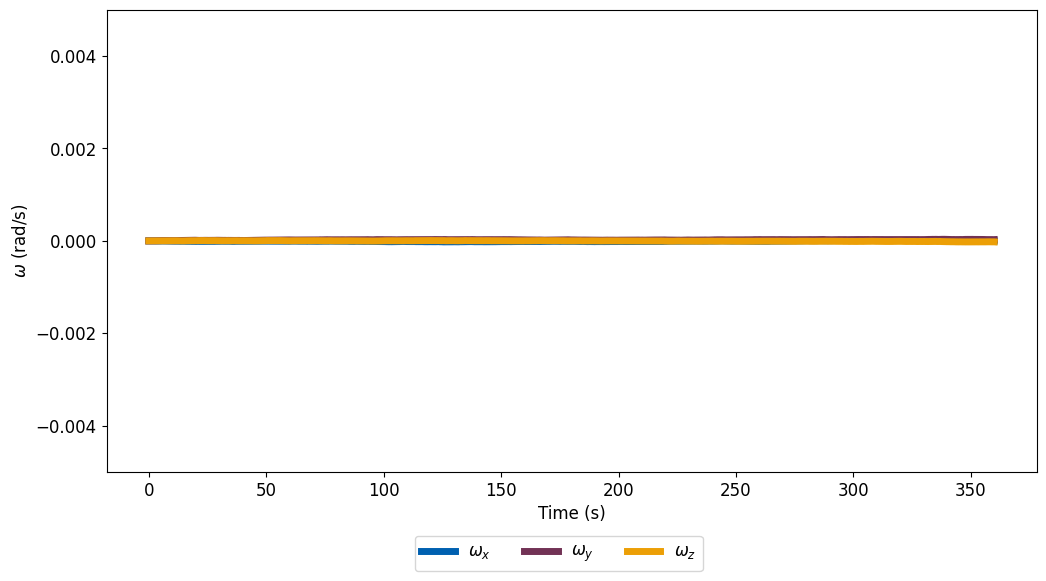

In [23]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,0])
# plt.plot(time, state_hist[:,1])
# plt.plot(time, state_hist[:,2])
# plt.title("omega")

fig2, ax2 = plt.subplots(figsize = (12, 6))
ax2.plot(time[:], state_hist[:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax2.plot(time[:], state_hist[:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax2.plot(time[:], state_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylim([-0.005, 0.005]) # using same units as above
ax2.set_ylabel("$\omega$ (rad/s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

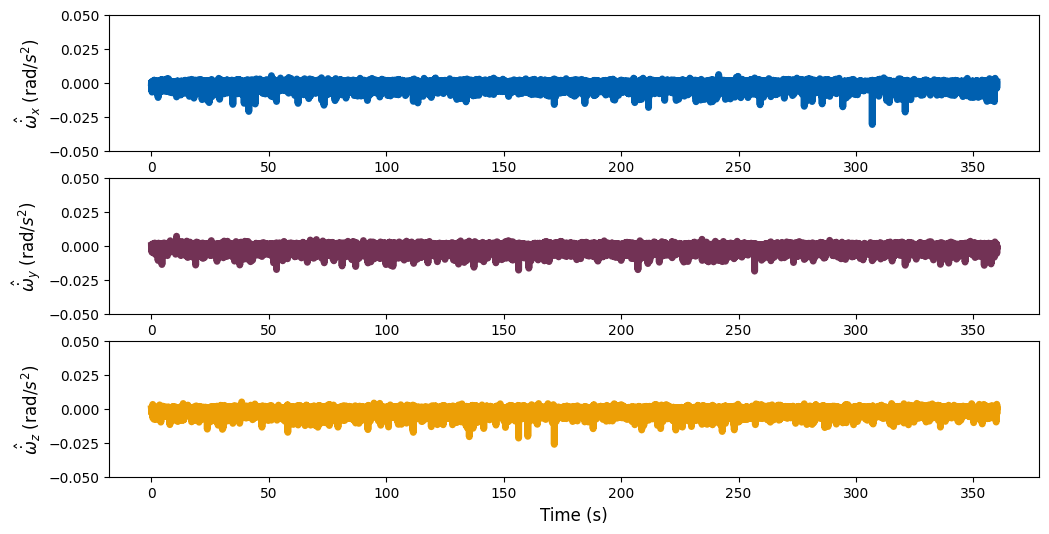

In [24]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,3])
# plt.plot(time, state_est_hist[:,4])
# plt.plot(time, state_est_hist[:,5])
# plt.title("omega dot")

fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax3[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax3[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax3[0].set_ylim([-0.05, 0.05])
ax3[1].set_ylim([-0.05, 0.05])
ax3[2].set_ylim([-0.05, 0.05])
ax3[0].set_ylabel("$\hat{\dot{\omega}}_x$ (rad/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{\dot{\omega}}_y$ (rad/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{\dot{\omega}}_z$ (rad/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 1.0, 'RW')

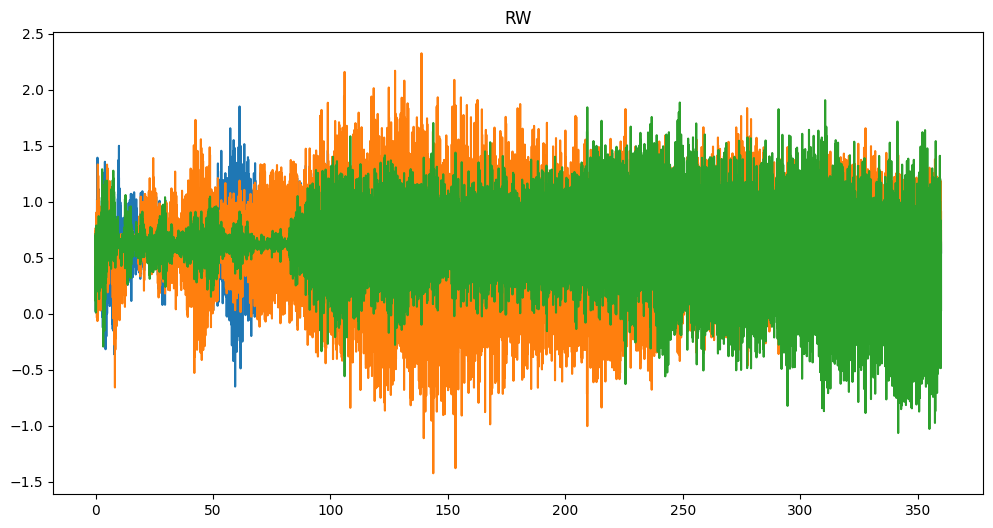

In [25]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,6])
plt.plot(time, state_est_hist[:,7])
plt.plot(time, state_est_hist[:,8])
plt.title("RW")

Text(0.5, 1.0, 'RW')

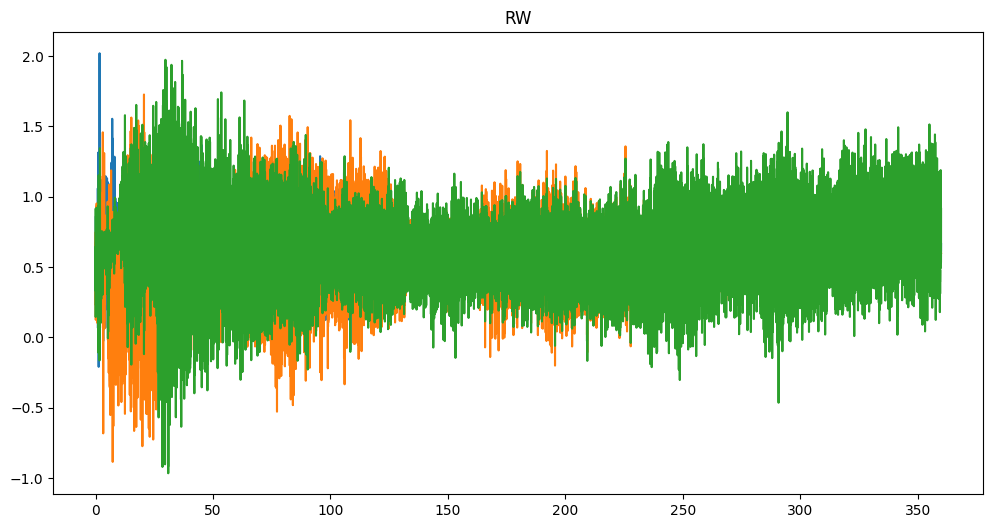

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,9])
plt.plot(time, state_est_hist[:,10])
plt.plot(time, state_est_hist[:,11])
plt.title("RW")

Text(0.5, 1.0, 'RW')

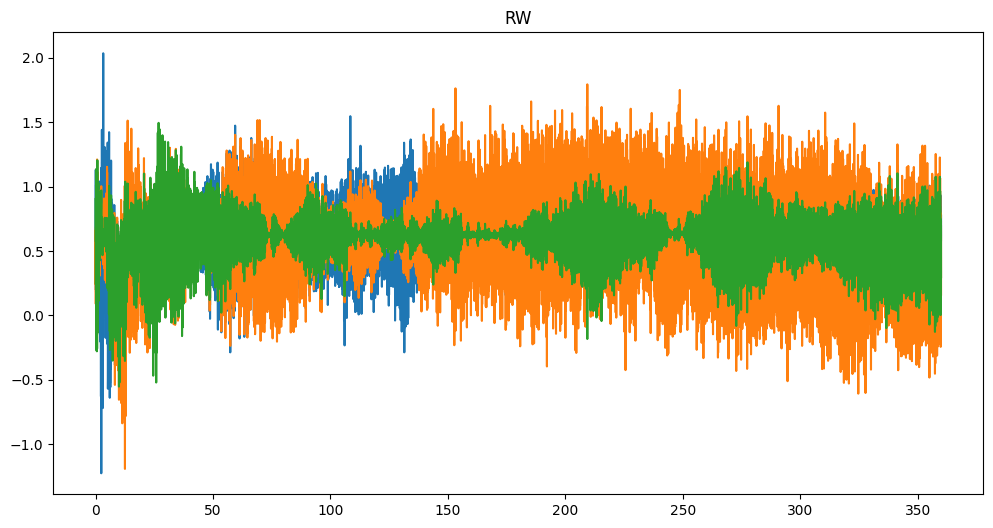

In [27]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,12])
plt.plot(time, state_est_hist[:,13])
plt.plot(time, state_est_hist[:,14])
plt.title("RW")

Text(0.5, 1.0, 'GM')

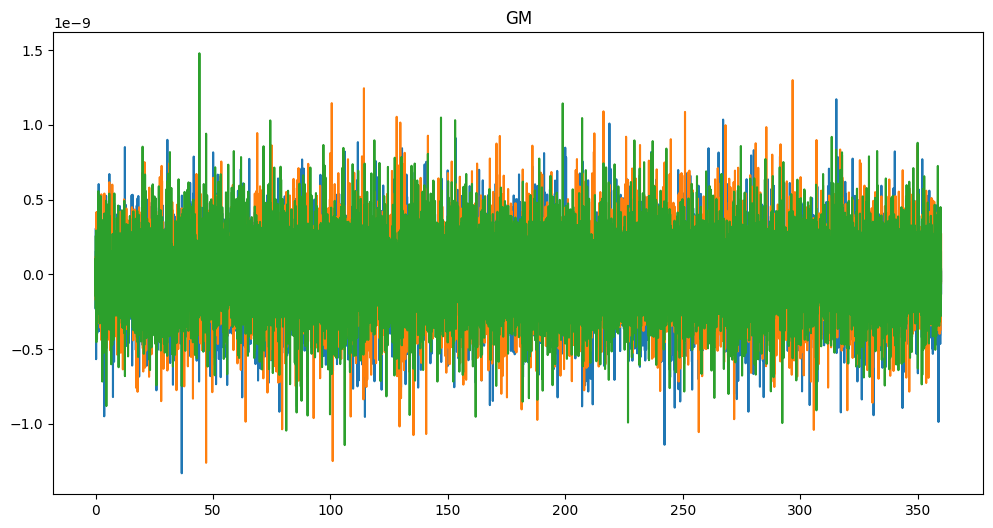

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,15])
plt.plot(time, state_est_hist[:,16])
plt.plot(time, state_est_hist[:,17])
plt.title("GM")